In [1]:
pip install timestring natsort

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import json
import timestring
import glob
from natsort import natsorted, ns

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [4]:
# define functions
# generate random string in case wanted to anonimize data
def generate_random_string(N):
    return "".join(random.SystemRandom().choice(string.ascii_lowercase + string.ascii_uppercase + string.digits)for _ in range(N))

# really specific function to extract data from tasks.json files to grab job count and walltime measures by speciifc groupings (by_key = user, app, project)
def extract_grouping_data(tasks,measure_key,by_key):
    
    # identify by_key list
    tmp_list = []
    for i in list(tasks.keys()):
        tmp_list = tmp_list + [ f[measure_key] for f in tasks[i][by_key] if f[measure_key] is not None and f[measure_key] != 0 ]

    tmp_list = np.unique(tmp_list)

    # set up variables to append through loop
    tmp_jobs = {}
    tmp_walltime = {}
    tmp = []
    dates = []
    counts = []
    walltime = []

    # loop through tmp list and grab stats per by_key over time
    for r in tmp_list:
        tmp_jobs[r] = []
        tmp_walltime[r] = []
        for i in list(tasks.keys()):
            dates = dates + [i]
            tmp = tmp + [r]
            tmp_index = [ f for f in range(len(tasks[i][by_key])) if tasks[i][by_key][f][measure_key] == r ]
            if tmp_index:
                tmp_index = tmp_index[0]
                tmp_jobs[r] = tmp_jobs[r] + [tasks[i][by_key][tmp_index]['jobCount']]
                tmp_walltime[r] = tmp_walltime[r] + [tasks[i][by_key][tmp_index]['jobWalltime']]
            else:
                tmp_jobs[r] = tmp_jobs[r] + [0]
                tmp_walltime[r] = tmp_walltime[r] + [0]

        counts = counts + tmp_jobs[r]
        walltime = walltime + tmp_walltime[r]

    # generate dataframe of important metrics 
    df = pd.DataFrame()
    df[measure_key] = tmp
    df['date'] = dates
    df['jobCount'] = counts
    df['walltime'] = walltime
    df.drop_duplicates(inplace=True)

    return df

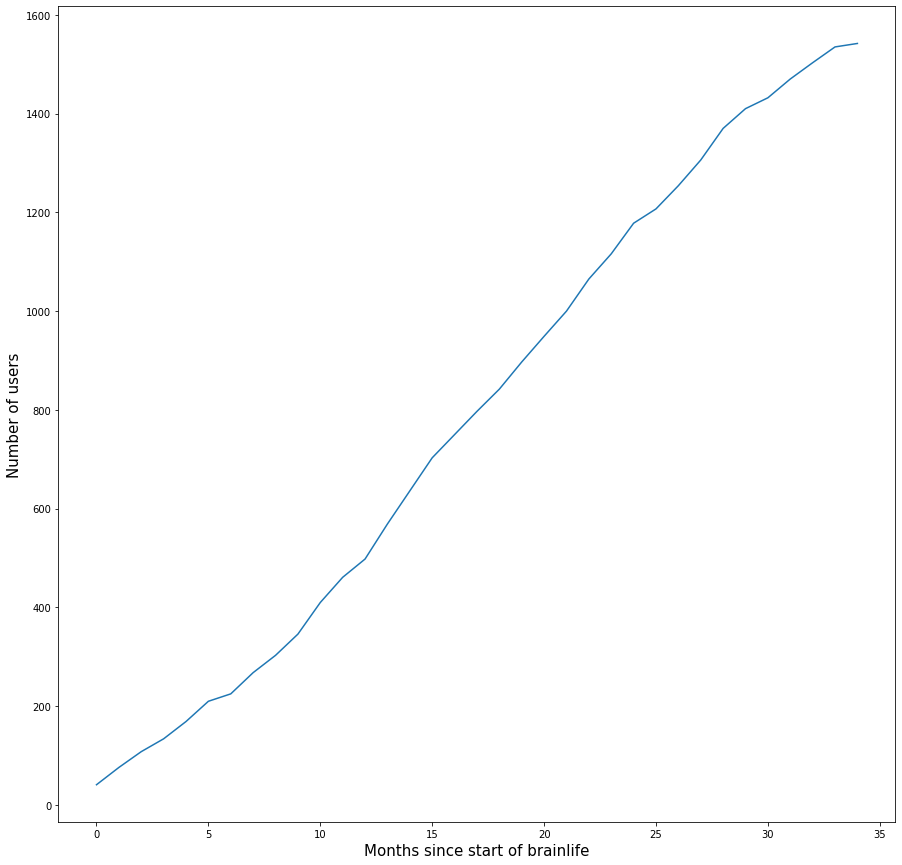

In [4]:
# Total number of user accounts created (an proxy for the attention received by the project)
# load users.confirmTimes data
users_confirm_times = pd.read_csv('./data/users.confirmTime.csv')

# update create_date to be proper datetime
create_date = []
for f in users_confirm_times['confirmTime']:
    if pd.notnull(f):
        if 'GMT' in str(f):
            tmp = f.replace(" (Coordinated Universal Time)","").replace(" GMT+0000","")
            create_date = create_date + [pd.to_datetime(tmp,dayfirst=True,utc=True,format="%a %b %d %Y %H:%M:%S")]
        else:
            create_date = create_date + [pd.to_datetime(f)]
    else:
        create_date = create_date + ['nan']

users_confirm_times['create_date'] = create_date

# groupby 1 month bins
one_month_users_confirm_times = users_confirm_times.loc[users_confirm_times['create_date'] != 'nan'].groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()
 
# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(one_month_users_confirm_times['create_date'])),y=one_month_users_confirm_times['sub'])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of users',size=15)
plt.savefig('./img/number_of_users_since_start_brainlife.png')
plt.savefig('./img/number_of_users_since_start_brainlife.eps')

In [5]:
# identify number of projects
# load data
project_stats = pd.read_json('./data/projects.stats.json')

# update create_date to be proper datetime
project_stats['create_date'] = pd.to_datetime(project_stats.create_date)

# groupby 1 month bins
# one_month_project_stats = project_stats.groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()

# # generate plot
# fig = plt.figure(figsize=(15,15))
# p = sns.lineplot(x=np.arange(0,len(one_month_project_stats['create_date'])),y=one_month_project_stats['name'])
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of projects',size=15)
# plt.savefig('./img/number_of_projects_since_start_brainlife.png')
# plt.savefig('./img/number_of_projects_since_start_brainlife.eps')

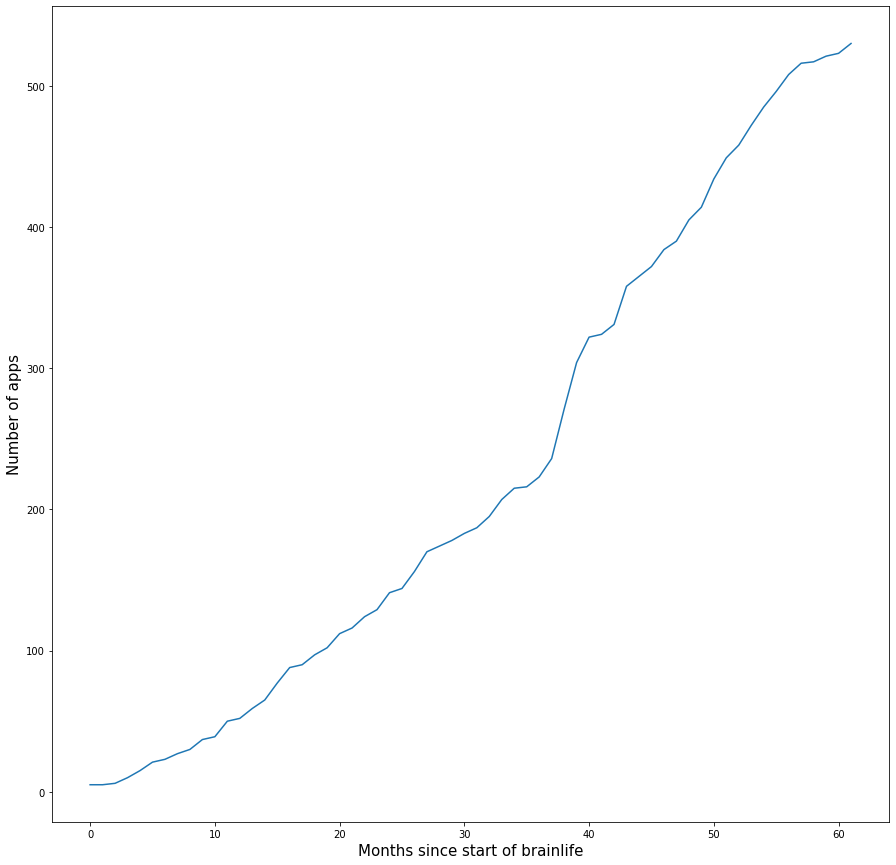

In [398]:
# identify number of apps
# load data
app_stats = pd.read_json('./data/apps.stats.json')

# update create_date to be proper datetime
app_stats['create_date'] = pd.to_datetime(app_stats.create_date)
app_stats

# groupby 1 month bins
one_month_app_stats = app_stats.groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(one_month_app_stats['create_date'])),y=one_month_app_stats['name'])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of apps',size=15)
plt.savefig('./img/number_of_apps_since_start_brainlife.png')
plt.savefig('./img/number_of_apps_since_start_brainlife.eps')

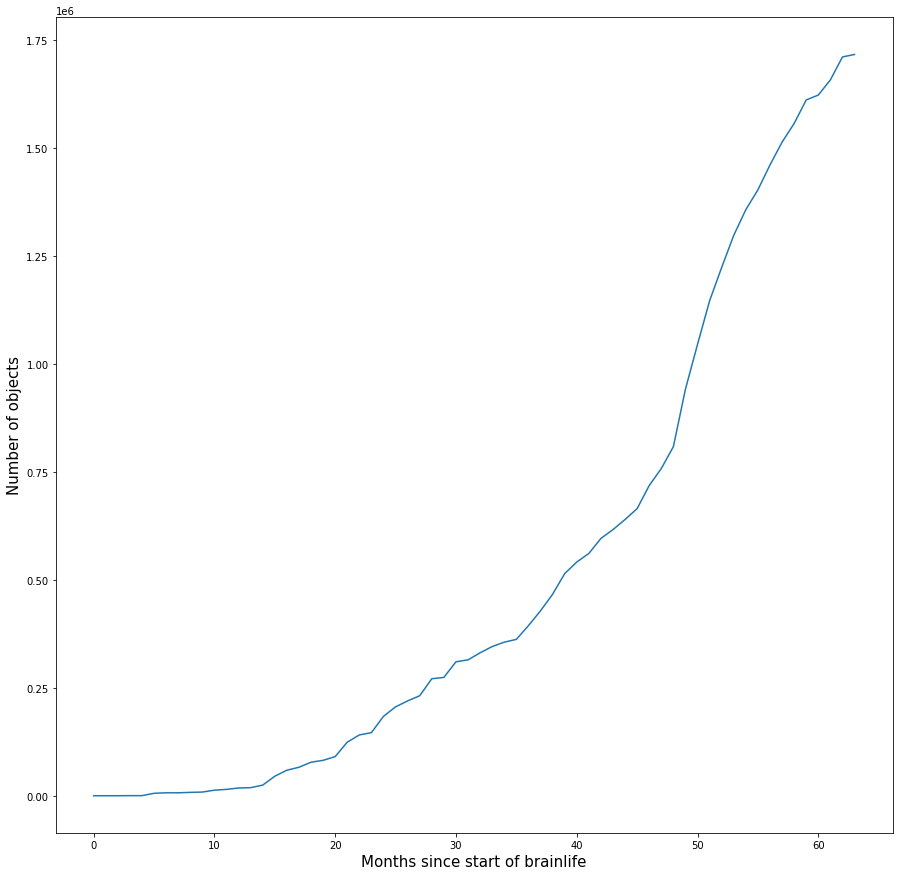

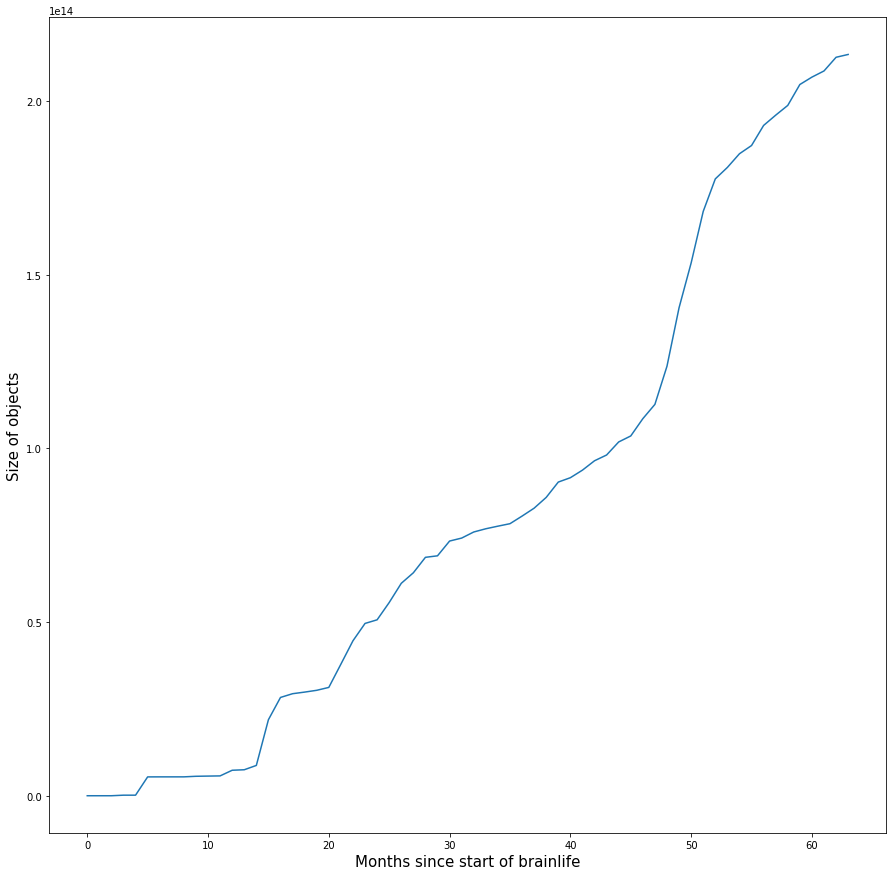

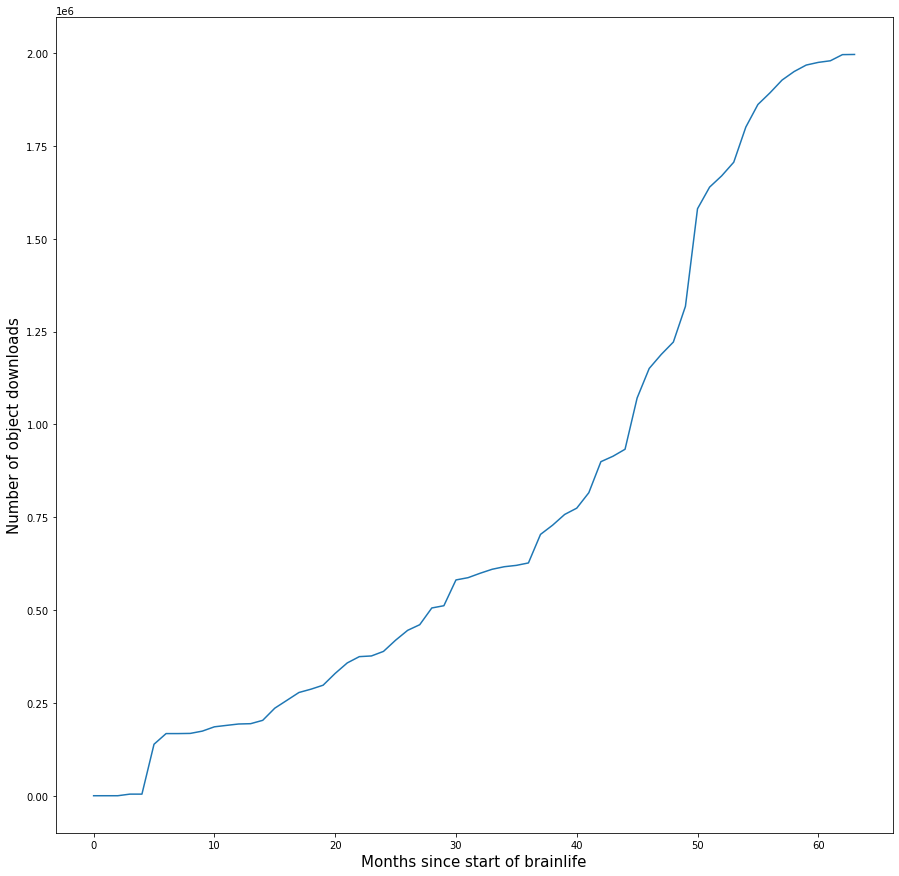

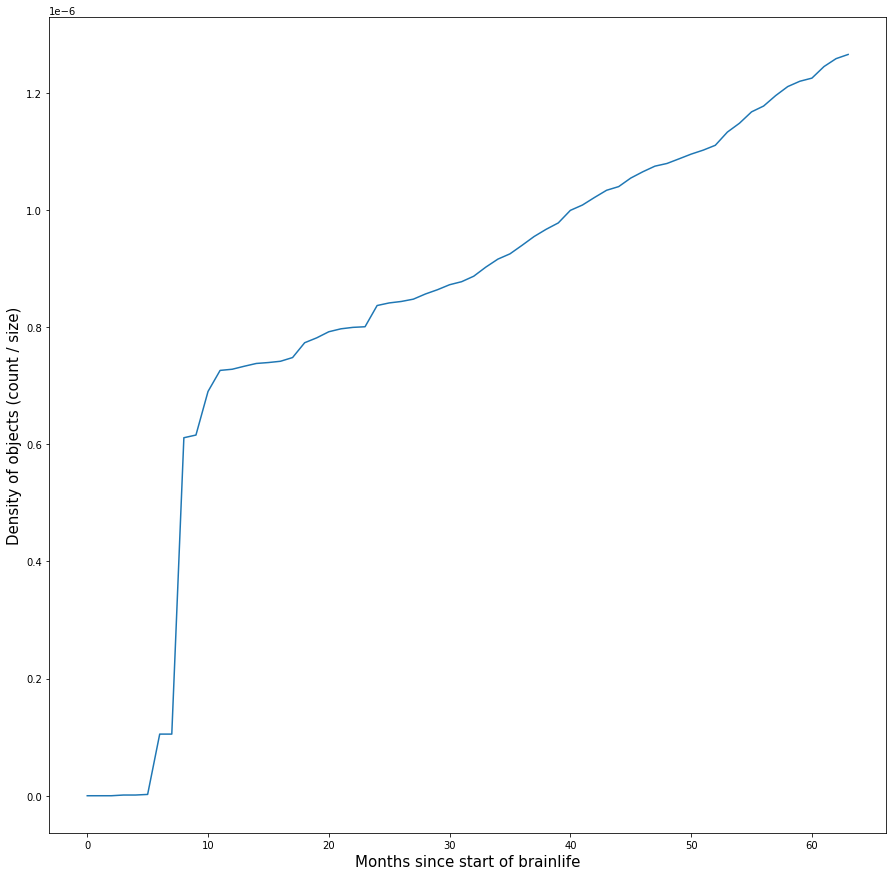

In [394]:
# number of objects and size of objects
# number of objects
# load data

object_files = sorted(glob.glob('./data/objects/*.json'))

# natural sort because the files don't have leading zeros :||||||||
years = ['2017','2018','2019','2020','2021','2022']

sorted_object_files = []

for i in years:
    tmp = [ f for f in object_files if i in f.split('objects.')[1].split('.')[1] ]
    sorted_object_files = sorted_files + natsorted(tmp, key=lambda y: y.lower())

# compile objects together
objects = {}

for i in range(len(sorted_object_files)):
    with open(sorted_object_files[i],'r') as file_f:
        obj_data = json.load(file_f)
    
    objects[sorted_object_files[i].split('objects.')[1].split('.json')[0]] = obj_data

dates = list(objects.keys())

objects_dataframe = pd.DataFrame()
objects_dataframe['date'] = [ f for f in range(len(objects)) ]
objects_dataframe['count'] = [ objects[f]['totalObjectCount'] for f in objects ]
objects_dataframe['size'] = [ objects[f]['totalObjectSize'] for f in objects ]
objects_dataframe['downloads'] = [ objects[f]['totalObjectDownload'] for f in objects ]
objects_dataframe['object_density'] = [ objects[f]['totalObjectCount'] / objects[f]['totalObjectSize'] if objects[f]['totalObjectSize'] != 0 else 0 for f in objects ]

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['count'][0:-7])),y=objects_dataframe['count'].cumsum()[0:-7])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of objects',size=15)
plt.savefig('./img/number_of_objects_since_start_brainlife.png')
plt.savefig('./img/number_of_objects_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['size'][0:-7])),y=objects_dataframe['size'].cumsum()[0:-7])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Size of objects',size=15)
plt.savefig('./img/size_of_objects_since_start_brainlife.png')
plt.savefig('./img/size_of_objects_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['downloads'][0:-7])),y=objects_dataframe['downloads'].cumsum()[0:-7])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of object downloads',size=15)
plt.savefig('./img/number_of_object_downloads_since_start_brainlife.png')
plt.savefig('./img/number_of_object_downloads_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['object_density'][0:-7])),y=objects_dataframe['object_density'].cumsum()[0:-7])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Density of objects (count / size)',size=15)
plt.savefig('./img/density_of_objects_since_start_brainlife.png')
plt.savefig('./img/density_of_objects_since_start_brainlife.eps')

In [5]:
# number of objects and size of objects
# number of objects
# load data

task_files = sorted(glob.glob('./data/tasks/*.json'))

# natural sort because the files don't have leading zeros :||||||||
years = ['2017','2018','2019','2020','2021','2022']

sorted_tasks_files = []

for i in years:
    tmp = [ f for f in task_files if i in f.split('tasks.')[1].split('.')[1] ]
    sorted_tasks_files = sorted_tasks_files + natsorted(tmp, key=lambda y: y.lower())
    
tasks = {}

for i in range(len(sorted_tasks_files)):
    with open(sorted_tasks_files[i],'r') as file_f:
        task_data = json.load(file_f)
    
    tasks[sorted_tasks_files[i].split('tasks.')[1].split('.json')[0]] = task_data

tasks_dataframe = pd.DataFrame()
tasks_dataframe['date'] = [ f for f in range(len(tasks)) ]
tasks_dataframe['walltime'] = [ tasks[f]['totalWalltime'] for f in tasks ]
tasks_dataframe['count'] = [ tasks[f]['totalJobCount'] for f in tasks ]
tasks_dataframe['resources_used'] = [ tasks[f]['totalResources'] for f in tasks ]

# # generate plot
# fig = plt.figure(figsize=(15,15))
# p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['walltime'][0:-7])),y=tasks_dataframe['walltime'].cumsum()[0:-7])
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_since_start_brainlife.eps')

# # generate plot
# fig = plt.figure(figsize=(15,15))
# p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['count'][0:-7])),y=tasks_dataframe['count'].cumsum()[0:-7])
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Number of Jobs Launched',size=15)
# plt.savefig('./img/total_number_jobs_since_start_brainlife.png')
# plt.savefig('./img/total_number_jobs_since_start_brainlife.eps')

# generate plot
# fig = plt.figure(figsize=(15,15))
# p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['resources_used'][0:-7])),y=tasks_dataframe['resources_used'].cumsum()[0:-7])
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Resources Used',size=15)
# plt.savefig('./img/total_resources_since_start_brainlife.png')
# plt.savefig('./img/total_resources_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


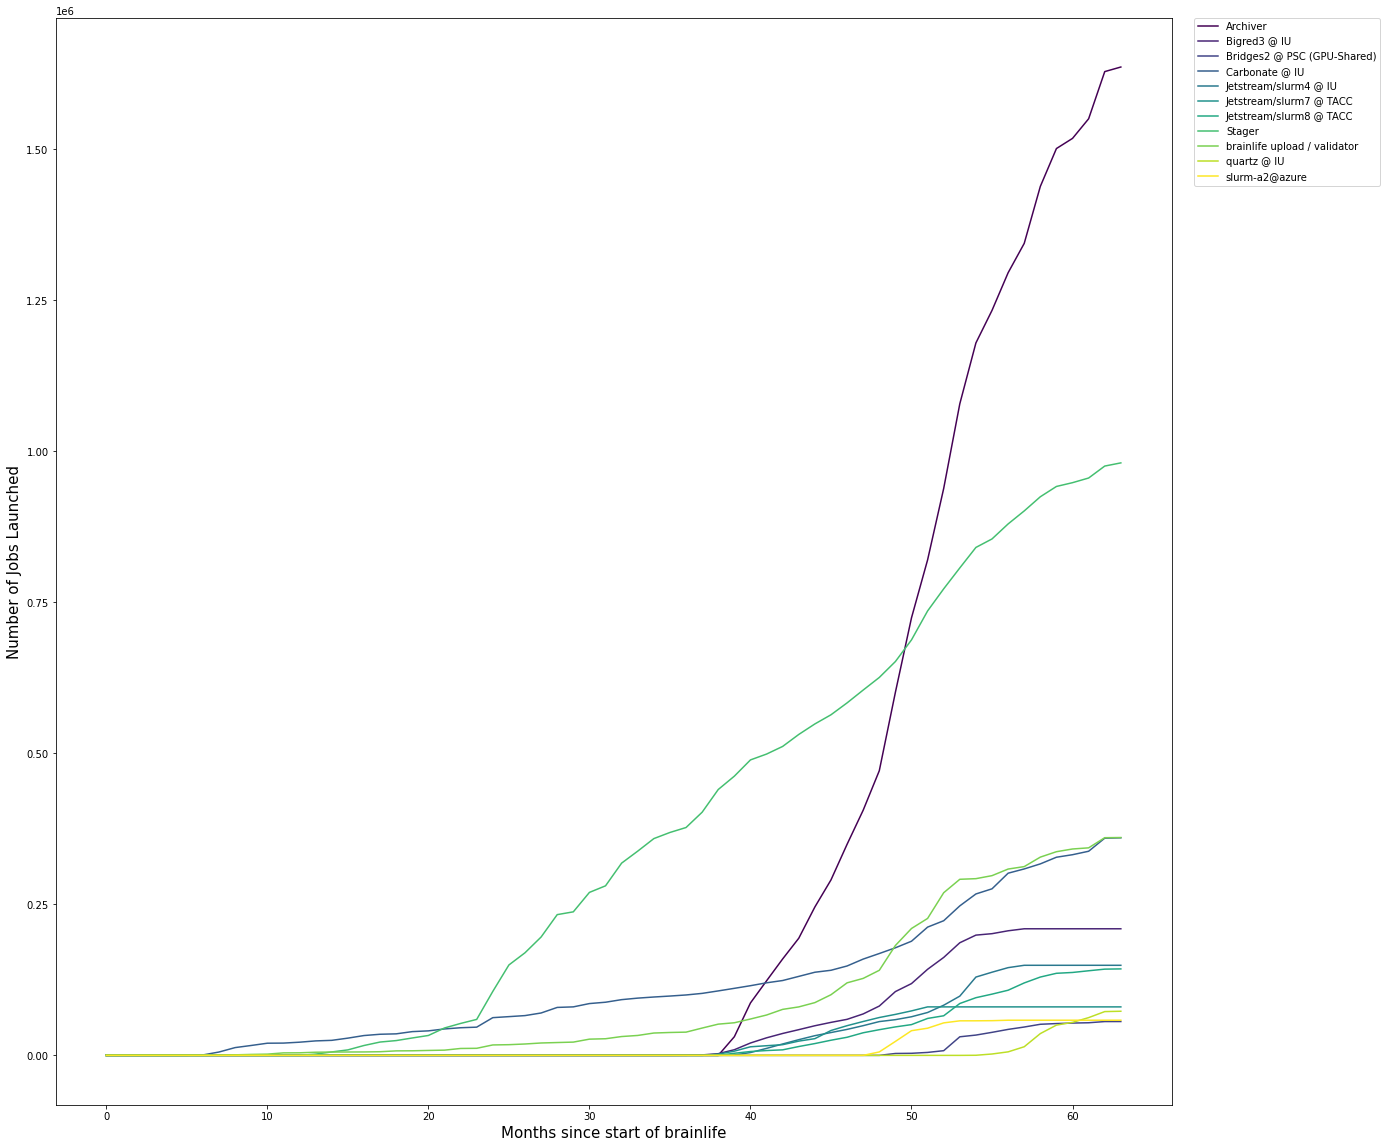

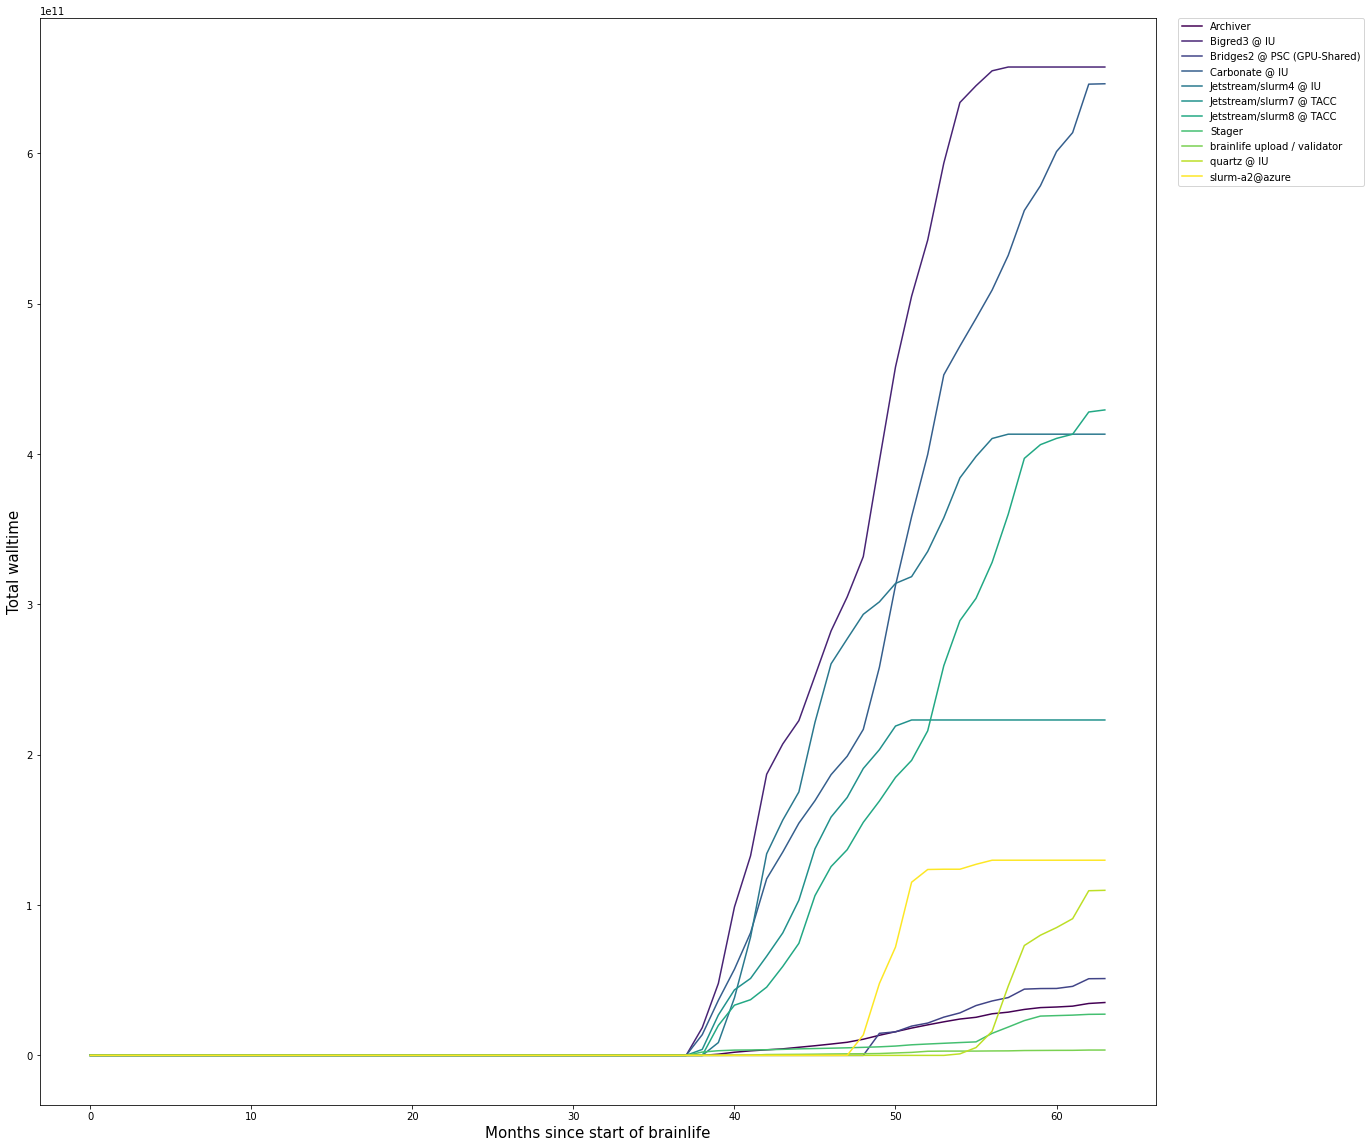

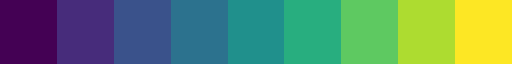

In [20]:
viridis

In [ ]:
# per resource breakdown
# extract job counts and walltime for resource grouping
tasks_resources = extract_grouping_data(tasks,'resourceName','byResources')

## figures
viridis = cm.get_cmap('viridis',len(tasks_resources.resource.unique()))

# create plot for number of jobs per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_resources.loc[tasks_resources['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_resource_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_resource_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_resources.loc[tasks_resources['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total walltime',size=15)
plt.savefig('./img/total_walltime_by_resource_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_resource_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


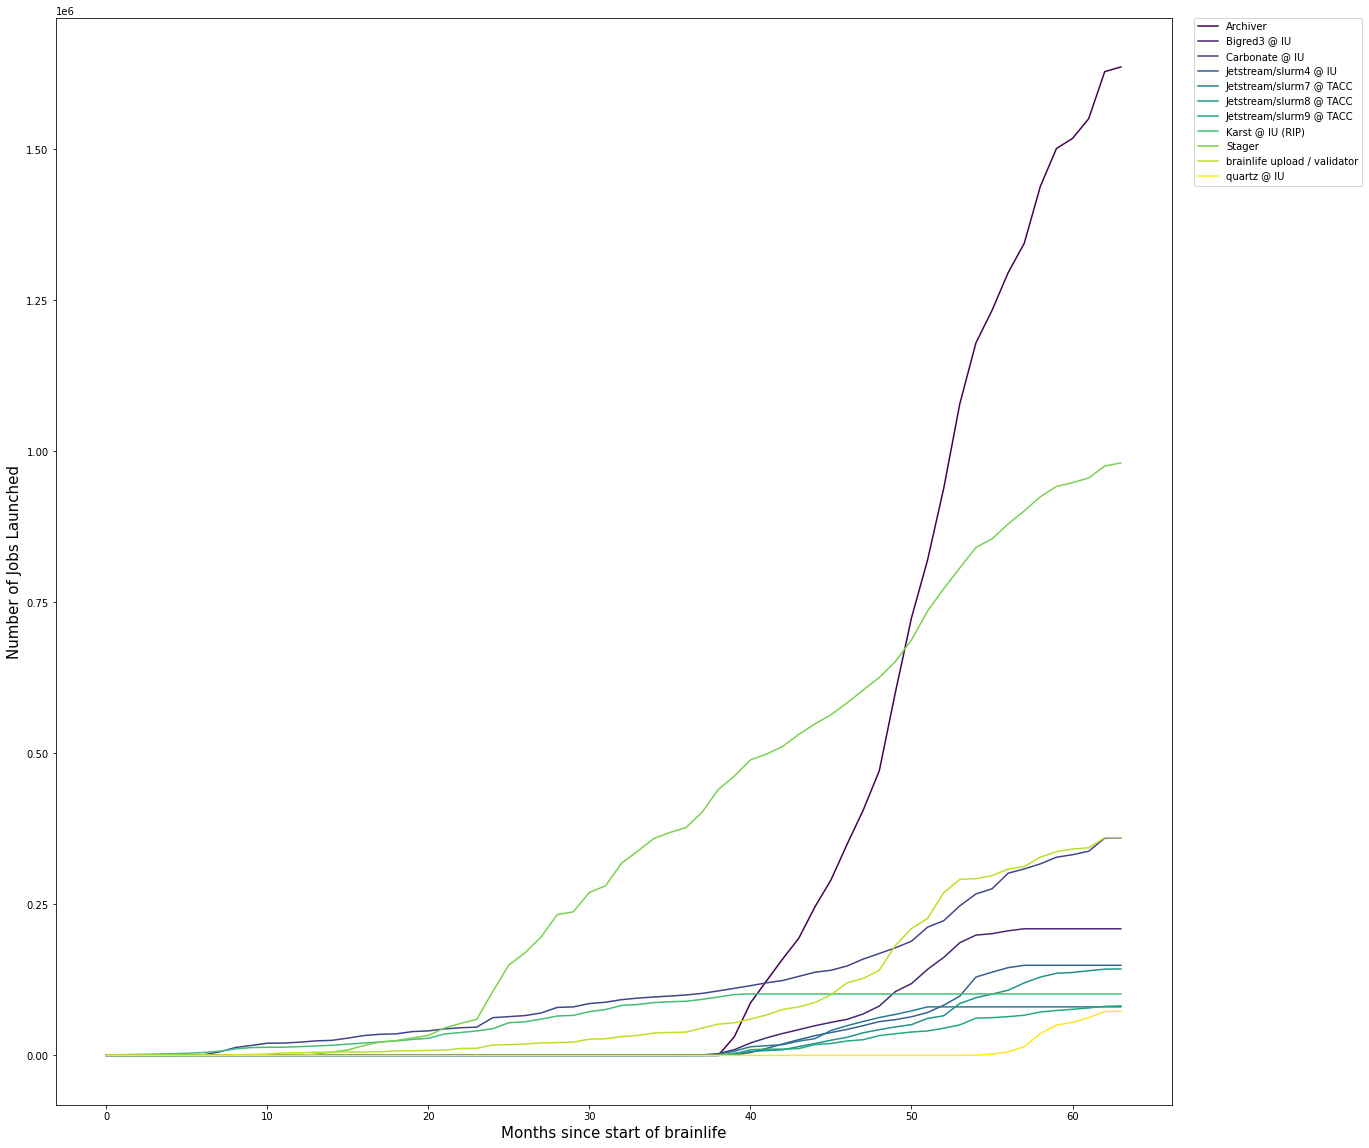

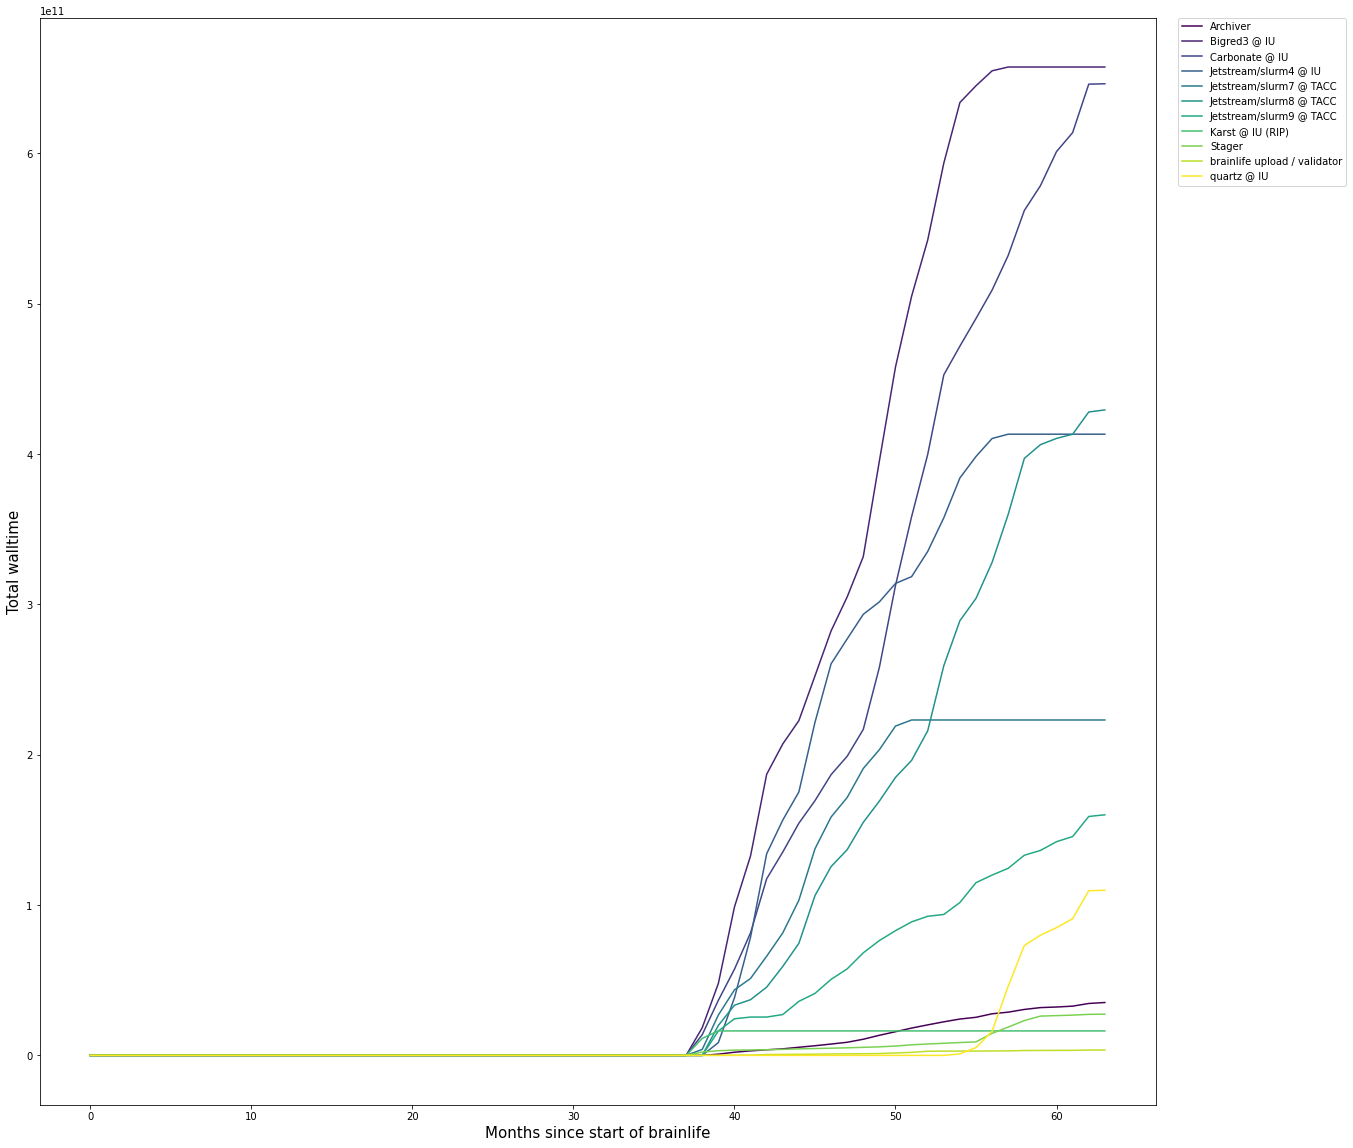

In [61]:
# per resource breakdown - top 10
# extract job counts and walltime for resource grouping
resources_top_10 = tasks_resources.groupby('resourceName',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:11]['resourceName'].to_list()
tasks_resources_top_10 = tasks_resources.loc[tasks_resources['resourceName'].isin(resources_top_10)]

## figures
viridis = cm.get_cmap('viridis',len(tasks_resources_top_10.resourceName.unique()))

# # create plot for number of jobs per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources_top_10.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_resources_top_10.loc[tasks_resources_top_10['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_resource_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_resource_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources_top_10.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_resources_top_10.loc[tasks_resources_top_10['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total walltime',size=15)
plt.savefig('./img/total_walltime_by_resource_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_resource_top_10_since_start_brainlife.eps')

In [26]:
# per user breakdown
# extract job counts and walltime for users grouping
tasks_users = extract_grouping_data(tasks,'sub','byUsers')
tasks_users['sub'] = [ str(f) for f in tasks_users['sub'] ]

# figures
# set colormap again with length of number of users
# viridis = cm.get_cmap('viridis',len(tasks_users['sub'].unique()))

# create plot for number of jobs per user over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_users['sub'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_users.loc[tasks_users['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_user_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_user_since_start_brainlife.eps')

# # # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_users['sub'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_users.loc[tasks_users['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_user_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_user_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


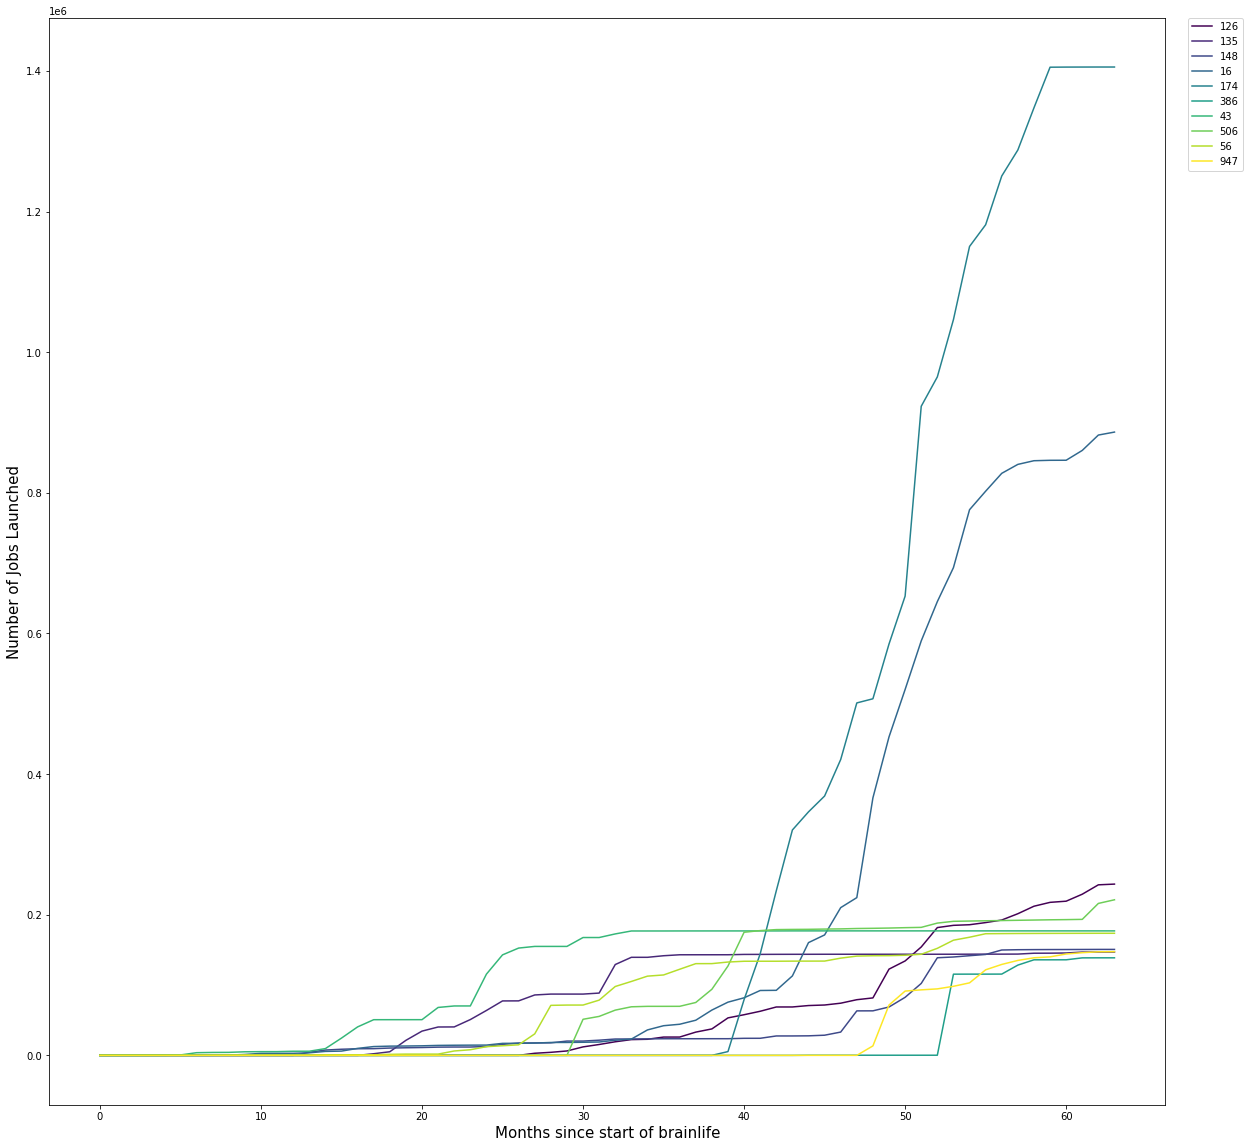

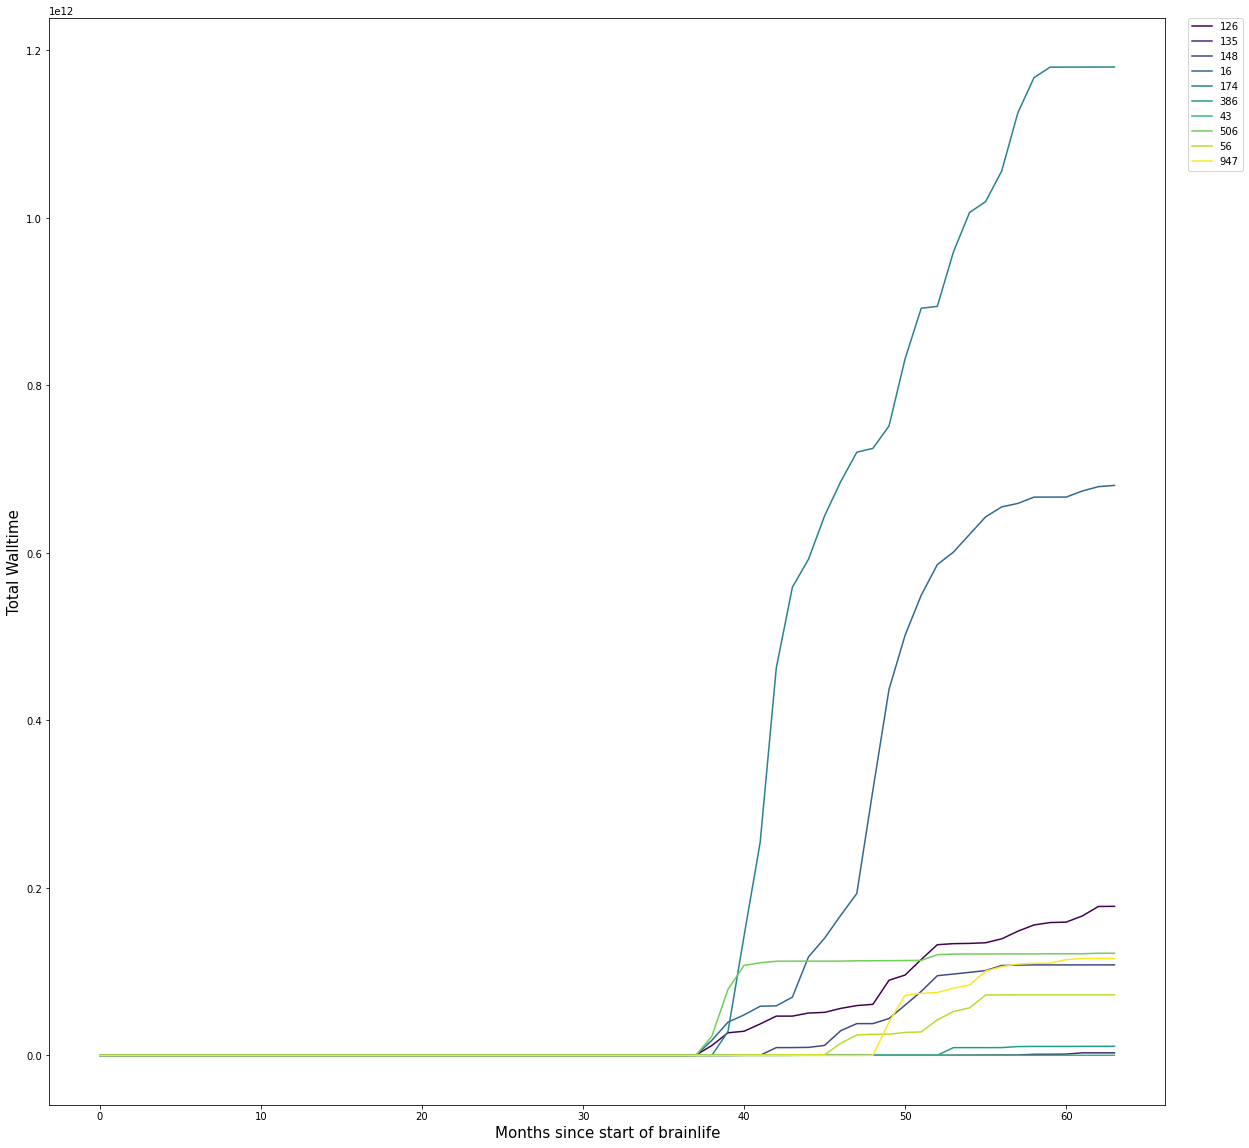

In [58]:
# per user breakdown - top 10
# extract job counts and walltime for users grouping
# tasks_users = extract_grouping_data(tasks,'sub','byUsers')
# tasks_users['sub'] = [ str(f) for f in tasks_users['sub'] ]
users_top_10 = tasks_users.groupby('sub',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:10]['sub'].to_list()
tasks_users_top_10 = tasks_users.loc[tasks_users['sub'].isin(users_top_10)]

# figures
# set colormap again with length of number of users
viridis = cm.get_cmap('viridis',len(tasks_users_top_10['sub'].unique()))

# create plot for number of jobs per user over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_users_top_10['sub'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_users_top_10.loc[tasks_users_top_10['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_user_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_user_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_users_top_10['sub'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_users_top_10.loc[tasks_users_top_10['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_user_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_user_top_10_since_start_brainlife.eps')

In [34]:
# find active users (more than 10 jobs launched per month)
active_subs = []
active_dates = []
active_counts = []
active_walltime = []

# for i in tasks_users['sub'].unique():
for d in tasks_users['date'].unique():
    tmp = tasks_users.loc[tasks_users['date'] == d]
    tmp_subs = tmp.loc[tmp['jobCount'] > 100]['sub'].tolist()
    tmp_counts = tmp.loc[tmp['jobCount'] > 100]['jobCount'].tolist()
    tmp_walltime = tmp.loc[tmp['jobCount'] > 100]['walltime'].tolist()


    active_subs = active_subs + tmp_subs
    active_dates = active_dates + [ d for f in tmp_subs ]
    active_counts = active_counts + tmp_counts
    active_walltime = active_walltime + tmp_walltime

active_tasks_users = pd.DataFrame()
active_tasks_users['sub'] = active_subs
active_tasks_users['date'] = active_dates
active_tasks_users['jobCount'] = active_counts
active_tasks_users['walltime'] = active_walltime
# active_tasks_users = active_tasks_users.sort_values(by=['sub','date'])

# # create plot for active users over time (more than >100 jobs in a month)
# fig = plt.figure(figsize=(20,20))
# sns.lineplot(x=np.arange(len(active_tasks_users.groupby('date',sort=False).count().cumsum())),y=active_tasks_users.groupby('date',sort=False).count().cumsum()['jobCount'])

# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total active users (> 100 jobs in a month)',size=15)
# plt.savefig('./img/number_active_users_since_start_brainlife.png')
# plt.savefig('./img/number_active_users_since_start_brainlife.eps')

<AxesSubplot:ylabel='jobCount'>

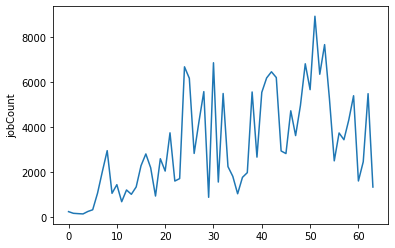

In [44]:
sns.lineplot(x=np.arange(len(active_tasks_users.groupby('date',sort=False).mean())),y=active_tasks_users.groupby('date',sort=False).mean()['jobCount'])


In [59]:
# per project breakdown
# extract job counts and walltime for project grouping
tasks_project = extract_grouping_data(tasks,'groupId','byGroup')

# figures
# set colormap again with length of number of users
# viridis = cm.get_cmap('viridis',len(tasks_project.groupId.unique()))

# # create plot for number of jobs per project over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_project['groupId'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_project.loc[tasks_project['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_project_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_project_since_start_brainlife.eps')

# # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_project['groupId'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_project.loc[tasks_project['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_project_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_project_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


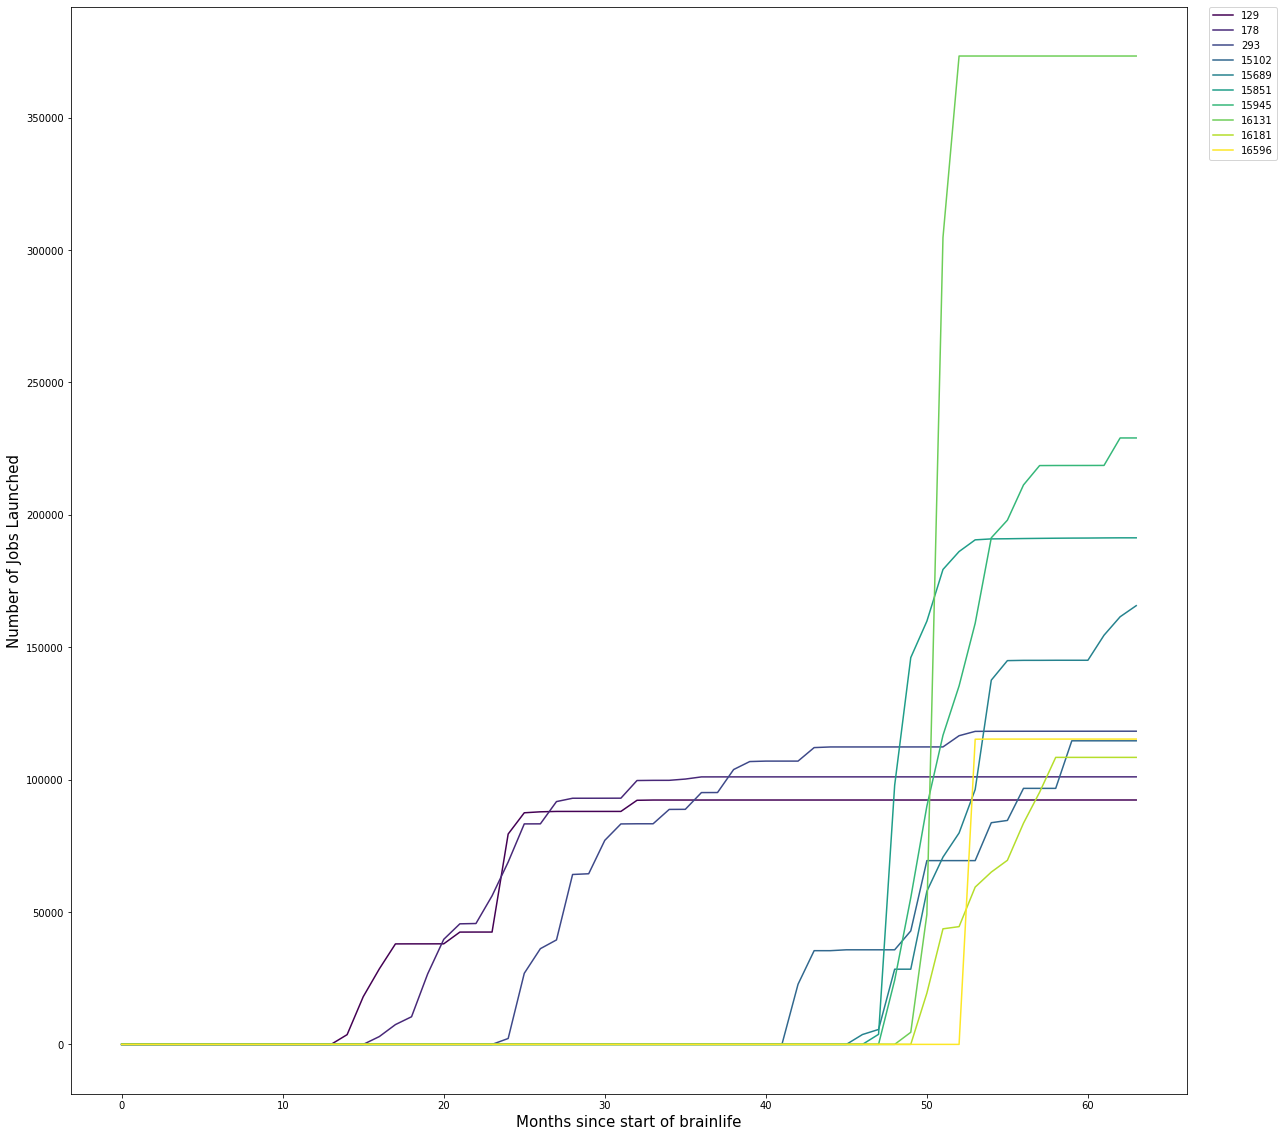

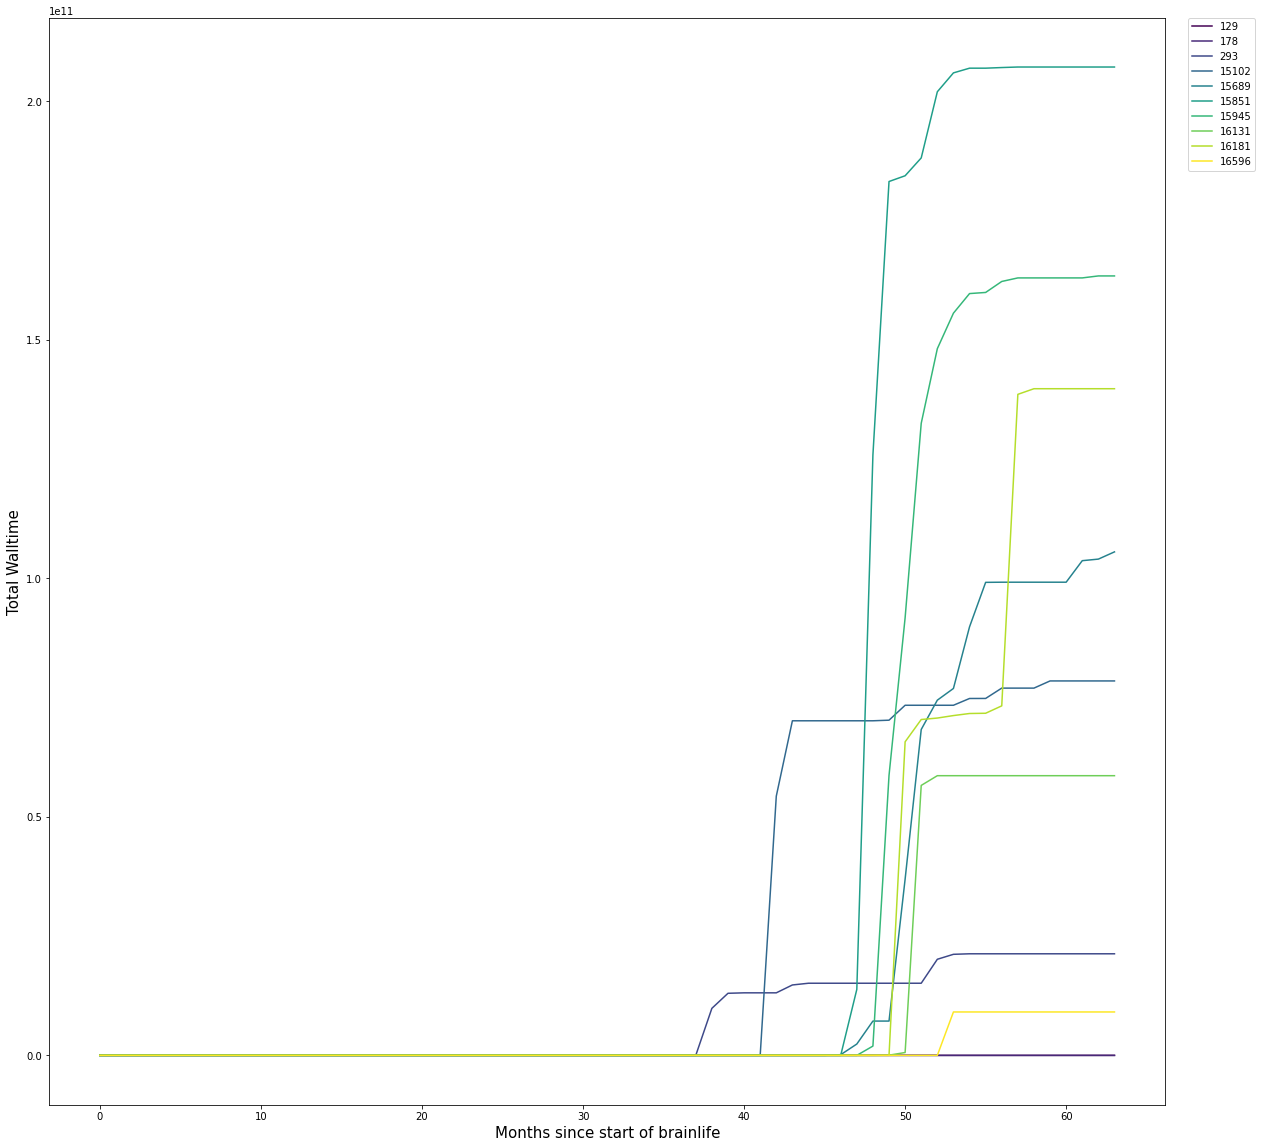

In [71]:
# per project breakdown - top 10
# extract job counts and walltime for project grouping
project_top_10 = tasks_project.groupby('groupId',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:10]['groupId'].to_list()
tasks_project_top_10 = tasks_project.loc[tasks_project['groupId'].isin(project_top_10)]

# figures
# set colormap again with length of number of users
viridis = cm.get_cmap('viridis',len(tasks_project_top_10.groupId.unique()))

# # create plot for number of jobs per project over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_project_top_10['groupId'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_project_top_10.loc[tasks_project_top_10['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_project_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_project_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_project_top_10['groupId'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_project_top_10.loc[tasks_project_top_10['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_project_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_project_top_10_since_start_brainlife.eps')

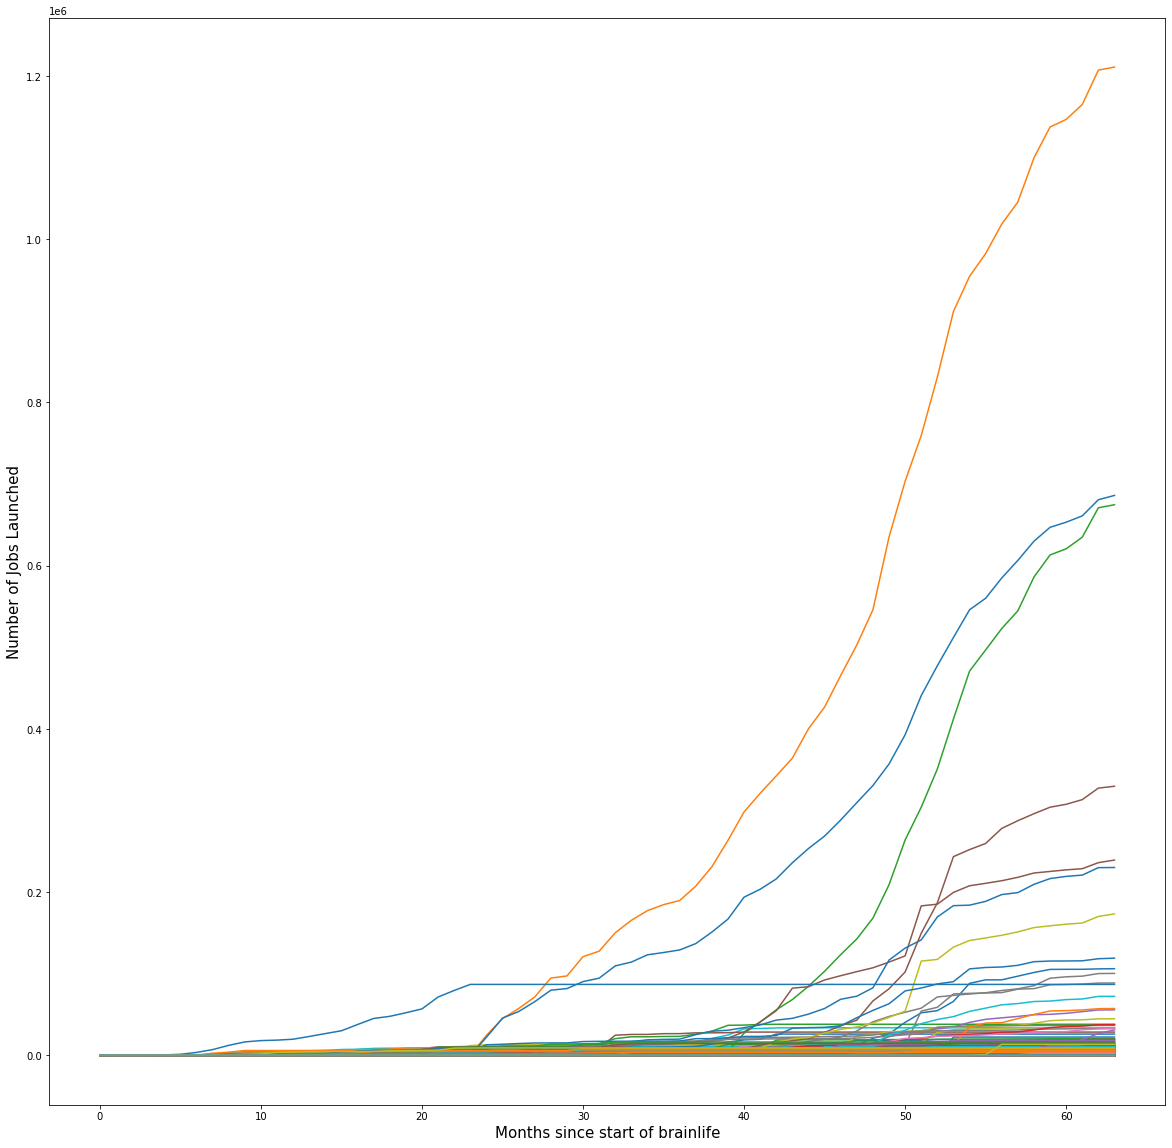

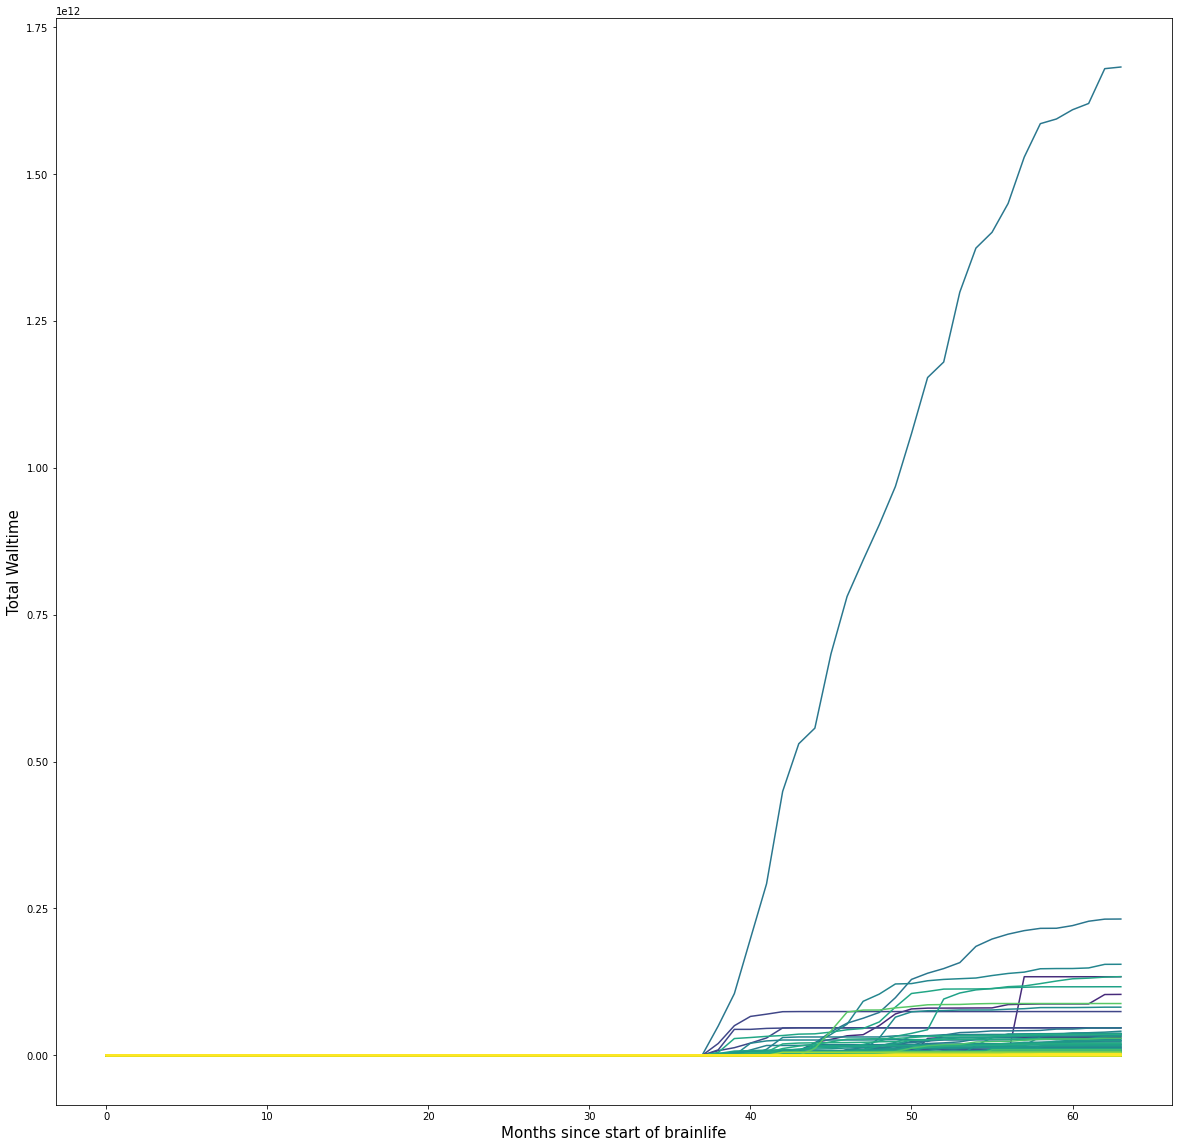

In [81]:
# per app breakdown
# extract job counts and walltime for app grouping
tasks_app = extract_grouping_data(tasks,'service','byServices')

## figures
# set colormap again with length of number of apps
viridis = cm.get_cmap('viridis',len(tasks_app.service.unique()))

# create plot for number of jobs per user over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_app['service'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_app.loc[tasks_app['service'] == r].cumsum()[0:-7])
    i=i+1
plt.legend('',frameon=False)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_app_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_app_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_app['service'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_app.loc[tasks_app['service'] == r].cumsum()[0:-7],color=viridis.colors[i])
    i=i+1
plt.legend('',frameon=False)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_app_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_app_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


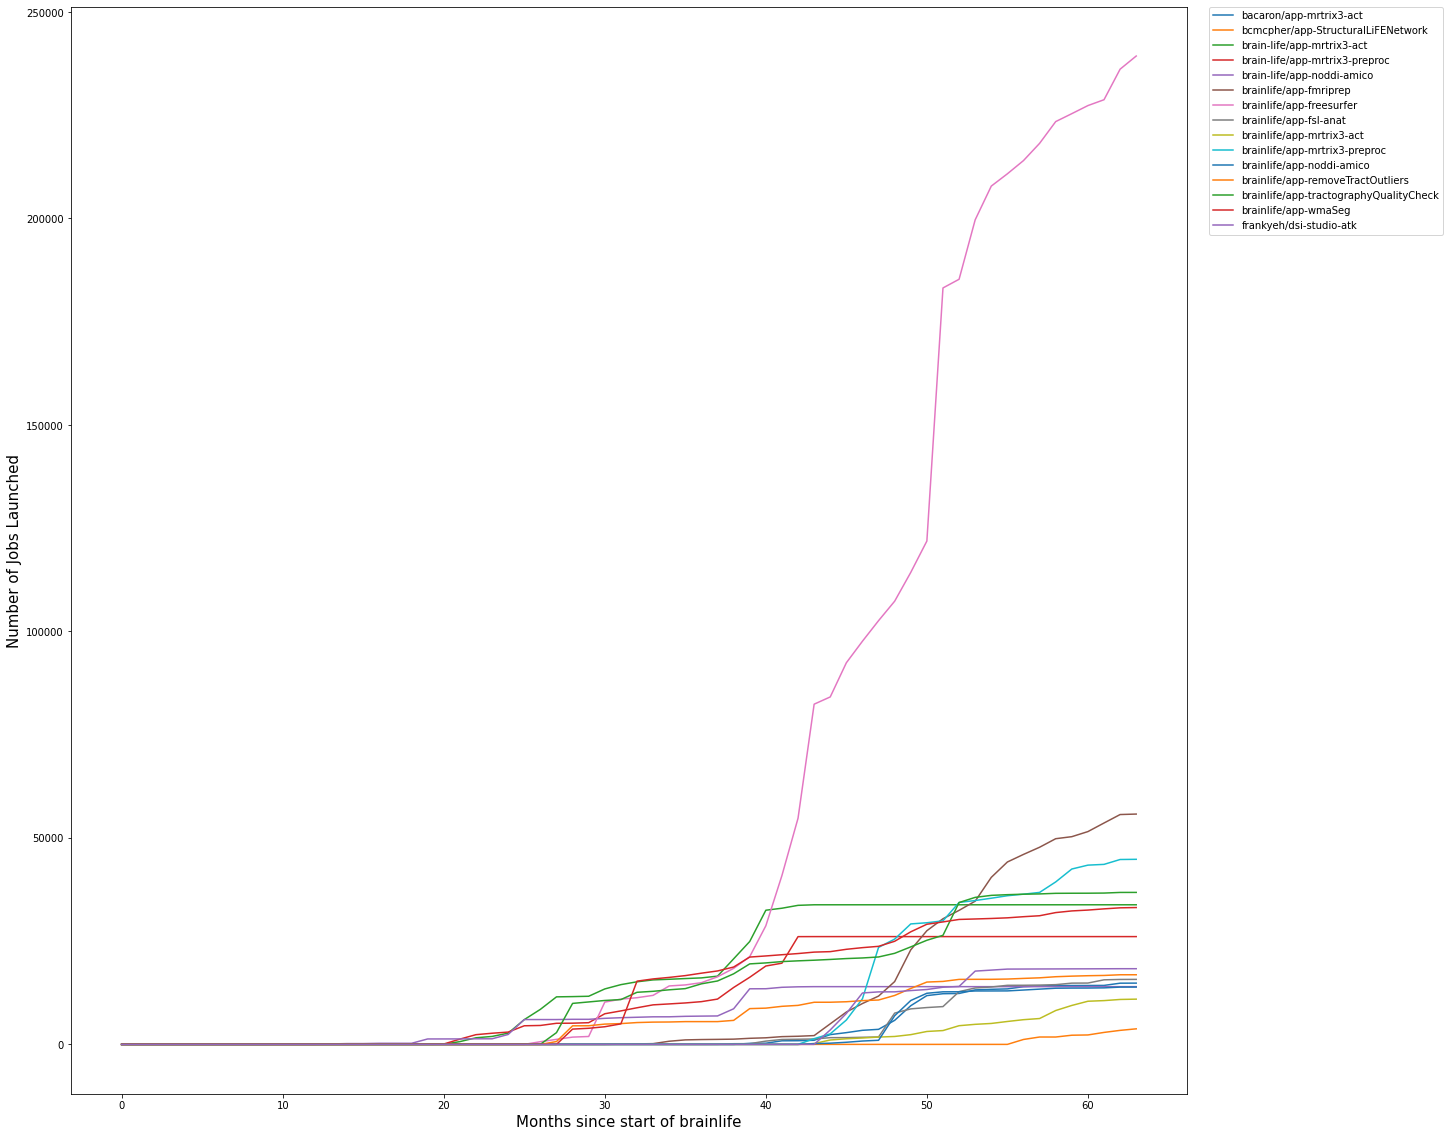

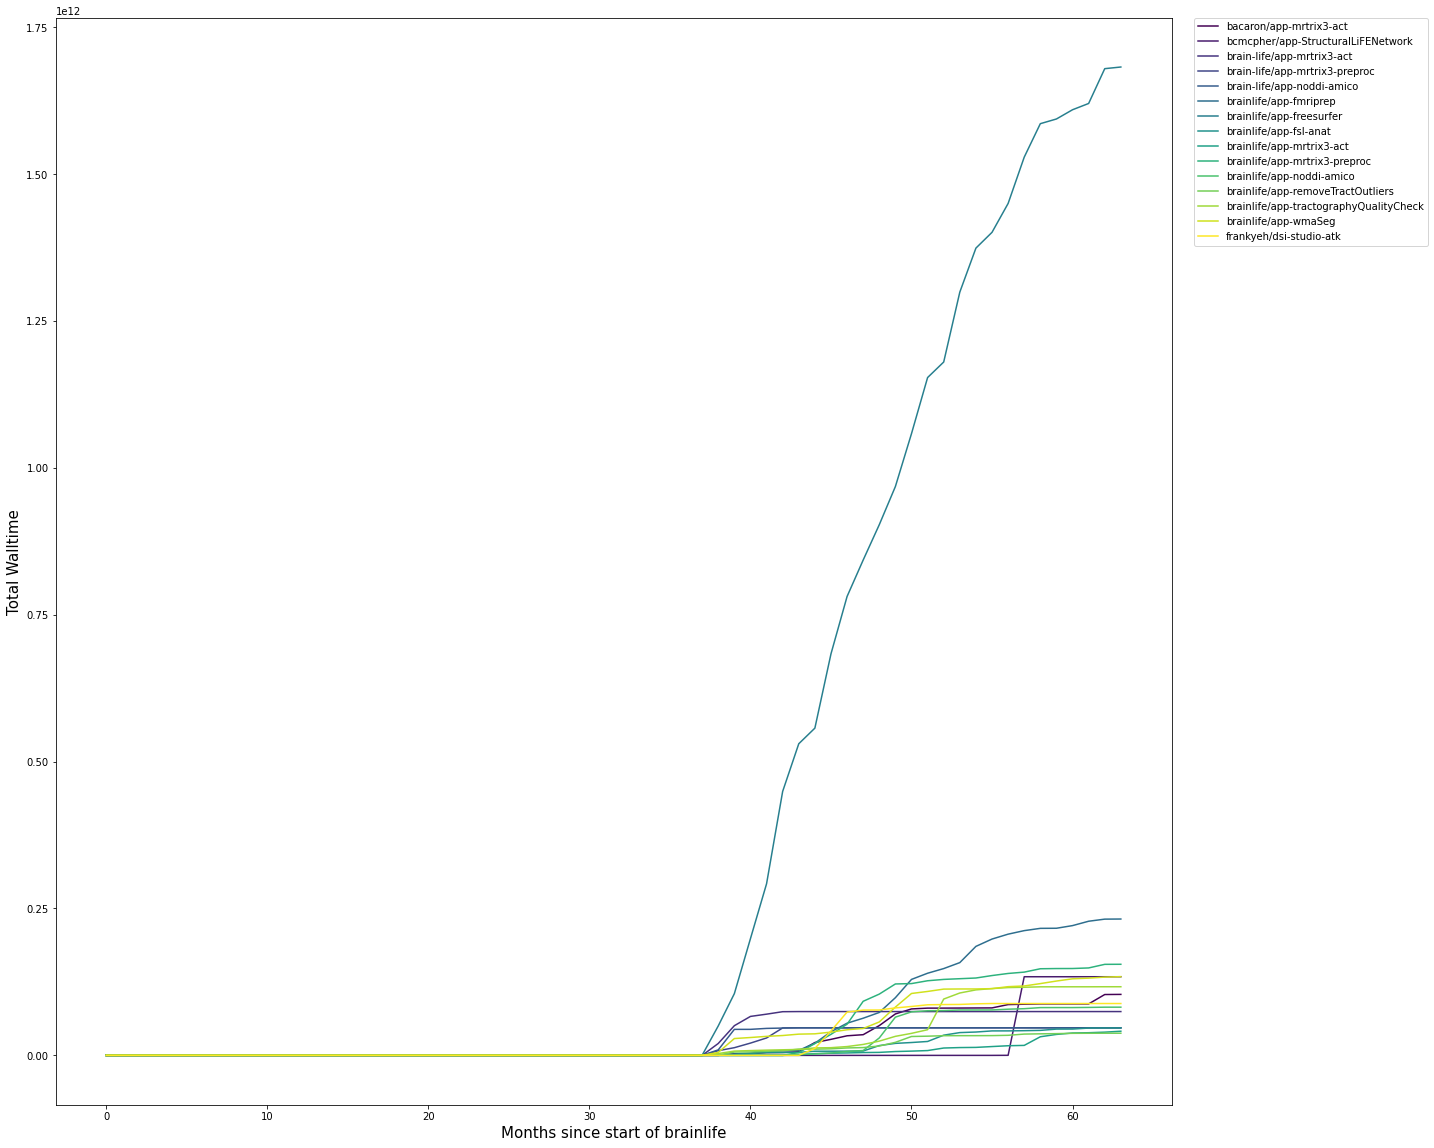

In [79]:
# per app breakdown - top 10
# extract job counts and walltime for app grouping
app_top_10 = tasks_app.groupby('service',as_index=False).sum().sort_values(by='walltime',ascending=False)[0:15]['service'].to_list()
tasks_app_top_10 = tasks_app.loc[tasks_app['service'].isin(app_top_10)]


## figures
# set colormap again with length of number of apps
viridis = cm.get_cmap('viridis',len(tasks_app_top_10.service.unique()))

# create plot for number of jobs per user over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_app_top_10['service'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_app_top_10.loc[tasks_app_top_10['service'] == r].cumsum()[0:-7],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_app_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_app_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_app_top_10['service'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_app_top_10.loc[tasks_app_top_10['service'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_app_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_app_top_10_since_start_brainlife.eps')